In [ ]:
library(phytools)
library(matlab)
library(igraph)
library(cloneid)
devtools::source_url("https://github.com/noemiandor/Utils/blob/master/getAllPathways.R?raw=TRUE")
devtools::source_url("https://github.com/noemiandor/Utils/blob/master/getGenesInvolvedIn.R?raw=TRUE")
devtools::source_url("https://github.com/noemiandor/Utils/blob/master/grpstats.R?raw=TRUE")
source("~/Projects/code/RCode/scripts/SingleCellUtils/quantifyPathways.R")

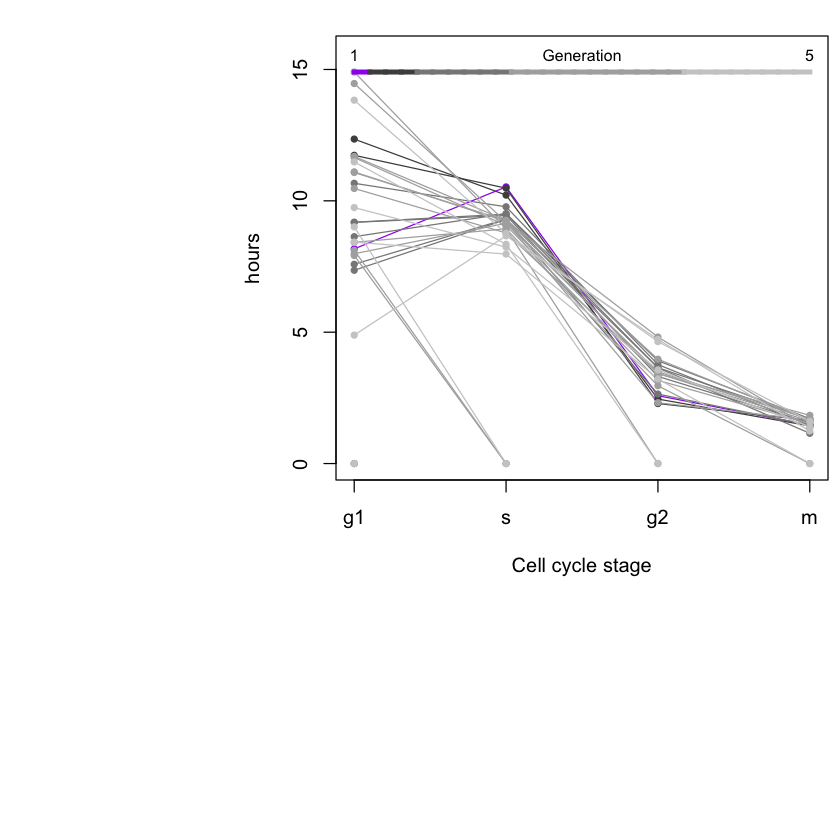

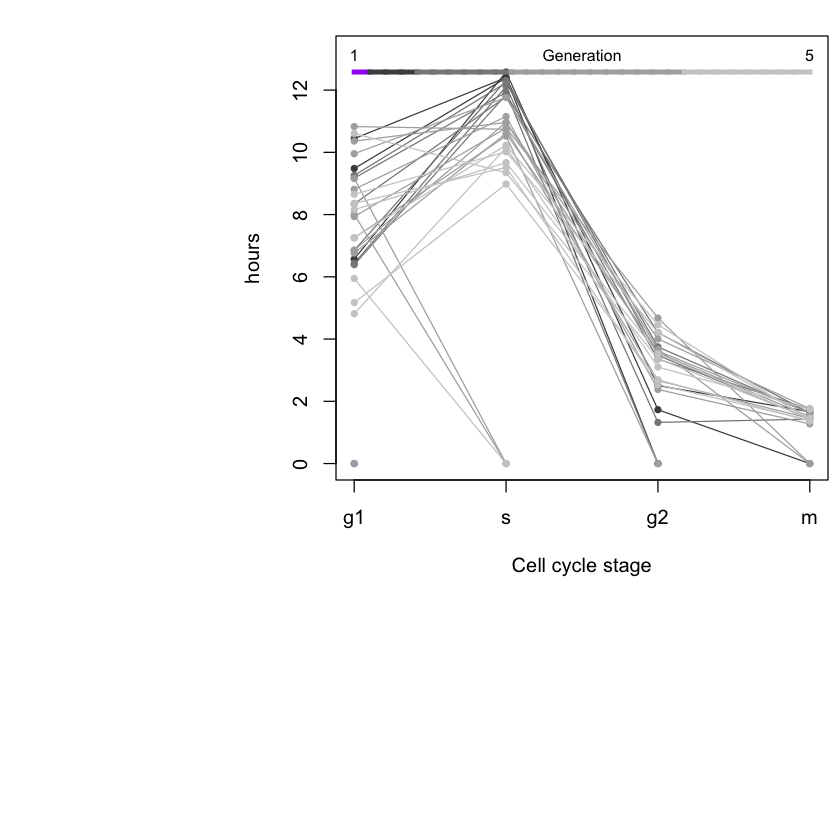

In [6]:
###################################
## Cell cycle: live cell imaging ##
nCells = 30;
dead = 0.1*nCells;
G1 = c(10,8); S = c(9,11); G2 =c(3.5,3.5); M = c(1.5,1.5)

par(mfrow = c(1,1), mai=c(3,2.8,0.3,0.1))
for(i in 1:2){
    g1 = rnorm(nCells,G1[i],G1[i]*0.2)
    s = sort(rnorm(nCells,S[i],S[i]*0.1),decreasing = T);
    g2 = rnorm(nCells,G2[i],G2[i]*0.2)
    m = rnorm(nCells,M[i],M[i]*0.1)

    g1[sample(length(g1),dead)]= 0;
    g2[sample(length(g2),dead)]= 0;
    s[sample(length(s),dead)]= 0;
    m[sample(length(m),dead)]= 0;
    
    cc = cbind(g1, s, g2, m);
    cc[cc[,1]==0,2:4]=NA
    cc[cc[,2]==0,3:4]=NA
    cc[cc[,3]==0,4]=NA
    cols = fliplr(gray.colors(log(nrow(cc),2)));
    cols = c("purple",cols)
    cols = cols[round(log(1:nrow(cc),2))];

    plot(c(1,4),quantile(cc,c(0,1), na.rm = T)*1.05, col='white', xlab = 'Cell cycle stage', ylab="hours", xaxt="n");
    axis(side=1, at=1:4, labels = c("g1","s","g2","m"))
    tmp = sapply(1:nrow(cc), function(x) lines(cc[x,], col=cols[x],lwd=1.5));
    tmp = sapply(1:nrow(cc), function(x) points(cc[x,], col=cols[x], pch=20));
    add.color.bar(3, cols,title = "Generation",prompt = F,outline = F, lwd=10, lims = c(1,round(log(nCells,2))),
                  subtitle="", y=max(cc, na.rm = T)*1.02, x=1, fsize=0.8)
}

In [22]:
############################
## Cell cycle: ReactomeDB ##
p=getAllPathways(loadPresaved = T)
idx = c(grep("ell Cycle",names(p)), grep("ell cycle",names(p)), grep("phase",names(p)))
p=p[unique(idx)]

actors <- data.frame(name=names(p));
from <- to <- c()

for(p1 in names(p)){
    for(p2 in setdiff(names(p), p1)){
        o = intersect(p[[p1]],p[[p2]]);
        thr = min(sapply(p[c(p1,p2)], length ))
        if(length(o) > 0.71*thr ){
            from = c(from, p1);
            to = c(to, p2);
        }
    }    
}
to = as.character(to)
from = as.character(from)

##Exclude singletons:
fr = plyr::count(from)
actors = as.character(fr$x[fr$freq>1]); 
relations <- data.frame(from=from[from %in% actors], to=to[to %in% actors]);

ig <- graph_from_data_frame(relations, directed=TRUE, vertices=actors)


In [6]:
###########################
## Cell cycle: scRNA-seq ##
## Retrieve transcriptome perspectives on clones ...
sName = "NUGC-4"
RNA="TranscriptomePerspective"
r_clones=cloneid::getSubclones(sName,RNA)
##... and their expression profiles:
r_profiles = gatherSCprofiles(r_clones[4], ccState="G0G1",whichP = RNA); ##at single-cell resolution
r_sps = t(grpstats(t(r_profiles$X), r_profiles$clones, statscols = "mean")$mean); ##at clone resolution
pq = quantifyPathways(r_sps,pgenes=p)
pq = pq*10

Loading required package: DBI


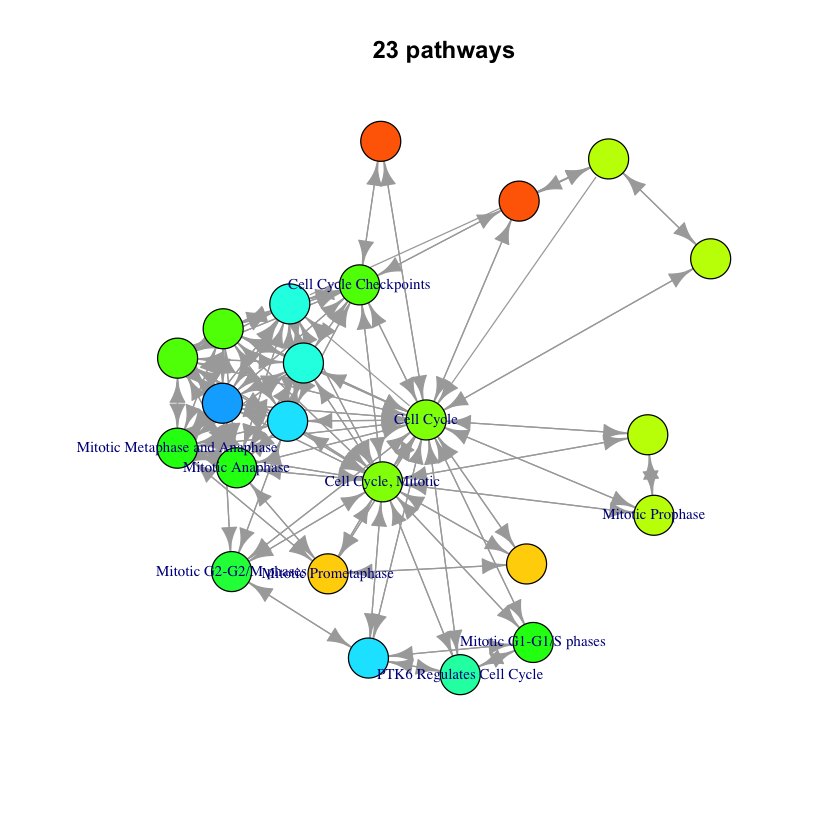

In [53]:
###################################
## Color ReactomeDB by scRNA-seq ##
col = rainbow(round(max(pq)*1.15));
col = col[round(pq[names(V(ig))])]
labels=names(V(ig))
labels[sapply(labels,nchar)>30]=""
#pdf("~/Downloads/reactomeCC_scRNA.pdf")
plot(ig, vertex.label=labels, vertex.label.cex = 0.75, main=paste(length(labels),"pathways"), vertex.color=col,edges.curved=-1, mark.border=NA,mark.shape = 1); #, mark.groups=as.list(1:length(p))
#dev.off()